In [1]:
import os
import sys

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

# Random Seeds
SEED=3093453
np.random.seed(SEED)



# Cosmetics
np.set_printoptions(
    edgeitems=30,
    linewidth=100_000,
    suppress=True
    )

sns.set(
    context="talk",
    style="darkgrid"
)


cwd = os.getcwd()
cwd, _ = os.path.split(cwd)

In [2]:


df = pd.DataFrame(columns = ["Set", "Filename", "raw"])


#for Set in ["A", "B", "C"]:
for Set in ["X-RERUN"]:
    path = os.path.join(cwd, "data", Set)
    for dirpath, dirnames, filenames in os.walk(path):
        filenames = sorted(filenames)
        for filename in filenames:
            if not filename.endswith(".out"):
                continue
            filepath = os.path.join(dirpath, filename)
            #print(filename)
            with open(filepath, "r") as f:
                raw_text = f.read()
            
            data = pd.DataFrame([[Set, filename[:-4], raw_text]], columns = ["Set", "Filename", "raw"])
            df = pd.concat([df, data])


#df = df[df.Filename.str.contains(r"[A-Z][A-Z]\d?\-\d{1,3}")]

#df = df[df["Filename"].str.len() >3]

df["Threshold"] = df["Filename"].str.extract("th(\d{3})").astype(float)
df["Run"] = df["Filename"].str.extract("run(\d{2})").astype(float)

df["Instance"] = df["Filename"].str.split("-").str[0]
df = df.sort_values(["Set", "Filename"]).reset_index(drop=True)

df = df[df["Instance"].str.endswith("6") | df["Instance"].str.endswith("7")]
df

,Set,Filename,raw,Threshold,Run,Instance
8,X-RERUN,AS6-run00,"cpu-bind=MASK - cn-0210, task 0 0 [1114191]:...",NaN,0.0,AS6
9,X-RERUN,AS6-run01,"cpu-bind=MASK - cn-0211, task 0 0 [675251]: ...",NaN,1.0,AS6
10,X-RERUN,AS6-run02,"cpu-bind=MASK - cn-0212, task 0 0 [3475912]:...",NaN,2.0,AS6
11,X-RERUN,AS6-run03,"cpu-bind=MASK - cn-0179, task 0 0 [3342477]:...",NaN,3.0,AS6
12,X-RERUN,AS6-run04,"cpu-bind=MASK - cn-0178, task 0 0 [689295]: ...",NaN,4.0,AS6
...,...,...,...,...,...,...
1015,X-RERUN,VA7-th080-run10,"cpu-bind=MASK - cn-0213, task 0 0 [1128467]:...",80.0,10.0,VA7
1016,X-RERUN,VA7-th080-run11,"cpu-bind=MASK - cn-0072, task 0 0 [2037439]:...",80.0,11.0,VA7
1017,X-RERUN,VA7-th080-run12,"cpu-bind=MASK - cn-0072, task 0 0 [2037675]:...",80.0,12.0,VA7
1018,X-RERUN,VA7-th080-run13,"cpu-bind=MASK - cn-0072, task 0 0 [2037901]:...",80.0,13.0,VA7


In [3]:
df["finalObjective"] = df.raw.str.extract("Final Solution\nObjective;(\d*\.?\d?)\nTransportation cost;").astype(float)
df["finalTransportationCost"] = df.raw.str.extract("Final Solution\nObjective;\d*\.?\d?\nTransportation cost;(\d*\.?\d?)").astype(float)
df["finalInventoryCost"] = df.raw.str.extract(
    "Final Solution\nObjective;\d*\.?\d?\nTransportation cost;\d*\.?\d?\nInventory cost;(\d*\.?\d?)"
).astype(float)
df["Runtime"] = df.raw.str.extract(
    "Final Solution\nObjective;\d*\.?\d?\nTransportation cost;\d*\.?\d?\nInventory cost;\d*\.?\d?\nRuntime;(\d*\.?\d?)"
).astype(float)
#df["finalObjective"].hist()

In [4]:
num_LNS_iterations = df["raw"].str.extractall(r"LNS iteration (\d*)").astype(int).reset_index().groupby("level_0")[0].max()

In [5]:
num_LNS_iterations = df["raw"].str.extractall(r"LNS iteration (\d*)").astype(int).reset_index().groupby("level_0")[0].max()
#num_LNS_iterations.index.name=
num_LNS_iterations.name = "num_LNS_iter"
df = df.join(num_LNS_iterations)
df["num_LNS_iter"] = df["num_LNS_iter"].fillna(0).astype(int)

In [6]:
df

,Set,Filename,raw,Threshold,Run,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter
8,X-RERUN,AS6-run00,"cpu-bind=MASK - cn-0210, task 0 0 [1114191]:...",NaN,0.0,AS6,9929873.0,9816000.0,113873.0,3591.0,3
9,X-RERUN,AS6-run01,"cpu-bind=MASK - cn-0211, task 0 0 [675251]: ...",NaN,1.0,AS6,9999614.0,9886500.0,113114.0,3599.7,3
10,X-RERUN,AS6-run02,"cpu-bind=MASK - cn-0212, task 0 0 [3475912]:...",NaN,2.0,AS6,10038128.0,9924000.0,114128.0,3595.5,3
11,X-RERUN,AS6-run03,"cpu-bind=MASK - cn-0179, task 0 0 [3342477]:...",NaN,3.0,AS6,9950687.0,9834000.0,116687.0,3598.8,3
12,X-RERUN,AS6-run04,"cpu-bind=MASK - cn-0178, task 0 0 [689295]: ...",NaN,4.0,AS6,9907032.0,9793500.0,113532.0,3497.6,3
...,...,...,...,...,...,...,...,...,...,...,...
1015,X-RERUN,VA7-th080-run10,"cpu-bind=MASK - cn-0213, task 0 0 [1128467]:...",80.0,10.0,VA7,29109.0,24000.0,5109.0,5.9,0
1016,X-RERUN,VA7-th080-run11,"cpu-bind=MASK - cn-0072, task 0 0 [2037439]:...",80.0,11.0,VA7,29109.0,24000.0,5109.0,6.4,0
1017,X-RERUN,VA7-th080-run12,"cpu-bind=MASK - cn-0072, task 0 0 [2037675]:...",80.0,12.0,VA7,29109.0,24000.0,5109.0,6.3,0
1018,X-RERUN,VA7-th080-run13,"cpu-bind=MASK - cn-0072, task 0 0 [2037901]:...",80.0,13.0,VA7,29109.0,24000.0,5109.0,6.3,0


(800000, 30000000)

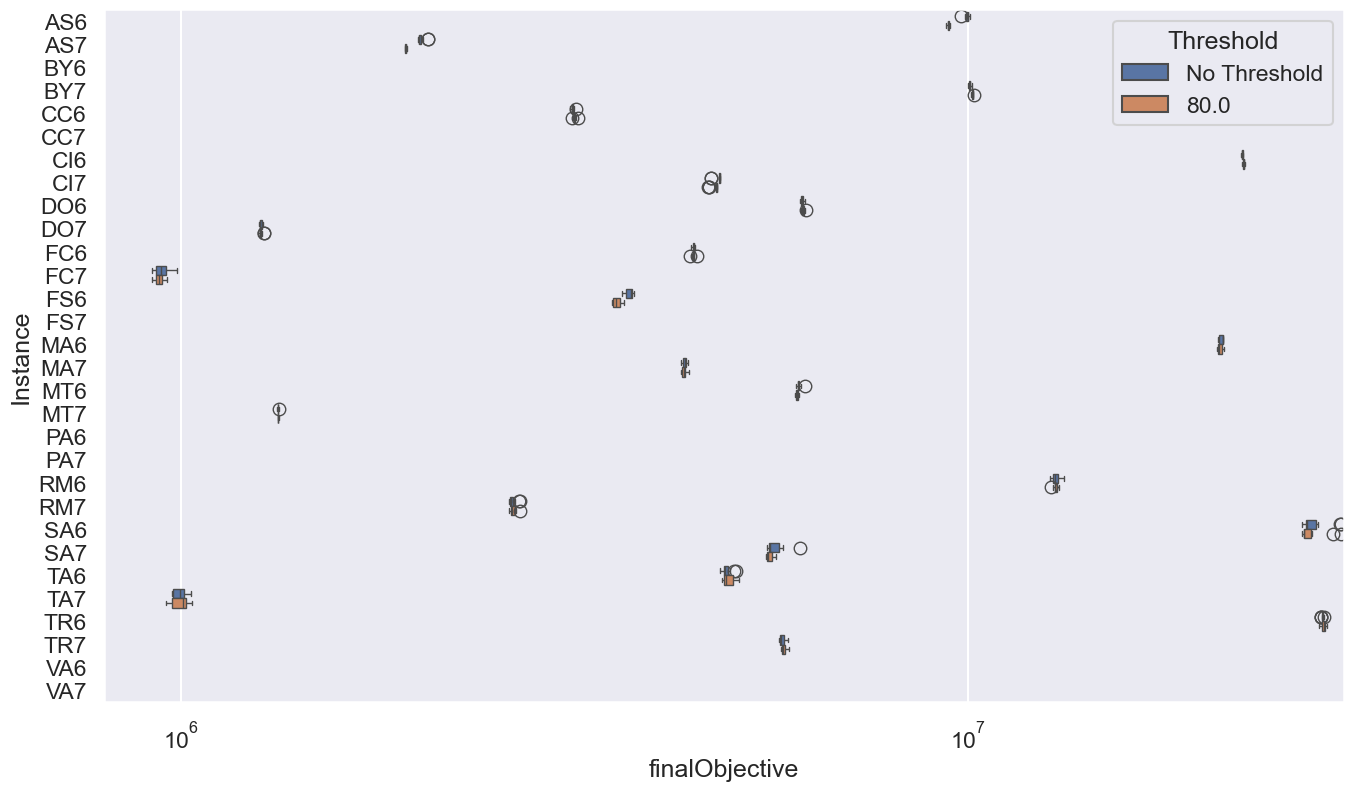

In [7]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.boxplot(data=df.fillna("No Threshold"), x="finalObjective", y="Instance", hue="Threshold", ax=ax);
plt.xscale("log")
plt.xlim([800_000, 30000_000])

In [8]:
reference_df = df[df.Threshold.isnull()].copy()
df = df[~df.Threshold.isnull()].copy().reset_index(drop=True)
df["Threshold"] = df["Threshold"].astype(int)
reference_df

,Set,Filename,raw,Threshold,Run,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter
8,X-RERUN,AS6-run00,"cpu-bind=MASK - cn-0210, task 0 0 [1114191]:...",NaN,0.0,AS6,9929873.0,9816000.0,113873.0,3591.0,3
9,X-RERUN,AS6-run01,"cpu-bind=MASK - cn-0211, task 0 0 [675251]: ...",NaN,1.0,AS6,9999614.0,9886500.0,113114.0,3599.7,3
10,X-RERUN,AS6-run02,"cpu-bind=MASK - cn-0212, task 0 0 [3475912]:...",NaN,2.0,AS6,10038128.0,9924000.0,114128.0,3595.5,3
11,X-RERUN,AS6-run03,"cpu-bind=MASK - cn-0179, task 0 0 [3342477]:...",NaN,3.0,AS6,9950687.0,9834000.0,116687.0,3598.8,3
12,X-RERUN,AS6-run04,"cpu-bind=MASK - cn-0178, task 0 0 [689295]: ...",NaN,4.0,AS6,9907032.0,9793500.0,113532.0,3497.6,3
...,...,...,...,...,...,...,...,...,...,...,...
1000,X-RERUN,VA7-run10,"cpu-bind=MASK - cn-0201, task 0 0 [2127763]:...",NaN,10.0,VA7,29109.0,24000.0,5109.0,6.0,0
1001,X-RERUN,VA7-run11,"cpu-bind=MASK - cn-0198, task 0 0 [2252399]:...",NaN,11.0,VA7,29109.0,24000.0,5109.0,6.2,0
1002,X-RERUN,VA7-run12,"cpu-bind=MASK - cn-0176, task 0 0 [4055100]:...",NaN,12.0,VA7,29109.0,24000.0,5109.0,6.3,0
1003,X-RERUN,VA7-run13,"cpu-bind=MASK - cn-0176, task 0 0 [4055102]:...",NaN,13.0,VA7,29109.0,24000.0,5109.0,6.3,0


In [9]:
reference_df_grouped = (
    reference_df
    .groupby(["Instance"])
    [["finalTransportationCost", "finalInventoryCost", "finalObjective", "Runtime", "num_LNS_iter"]]
    .mean()
    .reset_index()
)
reference_df_grouped

,Instance,finalTransportationCost,finalInventoryCost,finalObjective,Runtime,num_LNS_iter
0,AS6,9842000.0,113475.266667,9.955475e+06,3539.286667,3.000000
1,AS7,1948200.0,70111.533333,2.018312e+06,3518.426667,2.866667
2,BY6,46769400.0,812766.333333,4.758217e+07,3480.420000,5.000000
3,BY7,9822900.0,221060.933333,1.004396e+07,3533.246667,3.200000
4,CC6,3015300.0,128108.933333,3.143409e+06,1184.246667,5.533333
5,CC7,616300.0,50522.800000,6.668228e+05,1007.633333,3.400000
6,CI6,21969600.0,297851.333333,2.226745e+07,1684.573333,3.200000
7,CI7,4686800.0,130697.466667,4.817497e+06,1772.226667,1.000000
8,DO6,6006700.0,144045.866667,6.150746e+06,972.146667,4.333333
9,DO7,1222000.0,41291.266667,1.263291e+06,1113.580000,4.933333


In [10]:
df = df.merge(
    reference_df_grouped,
    #reference_df,
    how="left",
    on=[#"Set",
        "Instance"],
    suffixes=("", "_Reference"),
    
)
df.head()

,Set,Filename,raw,Threshold,Run,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter,finalTransportationCost_Reference,finalInventoryCost_Reference,finalObjective_Reference,Runtime_Reference,num_LNS_iter_Reference
0,X-RERUN,AS6-th080-run00,"cpu-bind=MASK - cn-0223, task 0 0 [1813650]:...",80,0.0,AS6,9437408.0,9324000.0,113408.0,2855.3,13,9842000.0,113475.266667,9.955475e+06,3539.286667,3.0
1,X-RERUN,AS6-th080-run01,"cpu-bind=MASK - cn-0179, task 0 0 [3329192]:...",80,1.0,AS6,9484282.0,9370500.0,113782.0,2813.3,12,9842000.0,113475.266667,9.955475e+06,3539.286667,3.0
2,X-RERUN,AS6-th080-run02,"cpu-bind=MASK - cn-0179, task 0 0 [3329191]:...",80,2.0,AS6,9366378.0,9252000.0,114378.0,2609.2,12,9842000.0,113475.266667,9.955475e+06,3539.286667,3.0
3,X-RERUN,AS6-th080-run03,"cpu-bind=MASK - cn-0179, task 0 0 [3329194]:...",80,3.0,AS6,9449312.0,9336000.0,113312.0,2617.0,15,9842000.0,113475.266667,9.955475e+06,3539.286667,3.0
4,X-RERUN,AS6-th080-run04,"cpu-bind=MASK - cn-0179, task 0 0 [3329193]:...",80,4.0,AS6,9486516.0,9375000.0,111516.0,2780.5,14,9842000.0,113475.266667,9.955475e+06,3539.286667,3.0


In [11]:
df

,Set,Filename,raw,Threshold,Run,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter,finalTransportationCost_Reference,finalInventoryCost_Reference,finalObjective_Reference,Runtime_Reference,num_LNS_iter_Reference
0,X-RERUN,AS6-th080-run00,"cpu-bind=MASK - cn-0223, task 0 0 [1813650]:...",80,0.0,AS6,9437408.0,9324000.0,113408.0,2855.3,13,9842000.0,113475.266667,9.955475e+06,3539.286667,3.0
1,X-RERUN,AS6-th080-run01,"cpu-bind=MASK - cn-0179, task 0 0 [3329192]:...",80,1.0,AS6,9484282.0,9370500.0,113782.0,2813.3,12,9842000.0,113475.266667,9.955475e+06,3539.286667,3.0
2,X-RERUN,AS6-th080-run02,"cpu-bind=MASK - cn-0179, task 0 0 [3329191]:...",80,2.0,AS6,9366378.0,9252000.0,114378.0,2609.2,12,9842000.0,113475.266667,9.955475e+06,3539.286667,3.0
3,X-RERUN,AS6-th080-run03,"cpu-bind=MASK - cn-0179, task 0 0 [3329194]:...",80,3.0,AS6,9449312.0,9336000.0,113312.0,2617.0,15,9842000.0,113475.266667,9.955475e+06,3539.286667,3.0
4,X-RERUN,AS6-th080-run04,"cpu-bind=MASK - cn-0179, task 0 0 [3329193]:...",80,4.0,AS6,9486516.0,9375000.0,111516.0,2780.5,14,9842000.0,113475.266667,9.955475e+06,3539.286667,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,X-RERUN,VA7-th080-run10,"cpu-bind=MASK - cn-0213, task 0 0 [1128467]:...",80,10.0,VA7,29109.0,24000.0,5109.0,5.9,0,24000.0,5109.000000,2.910900e+04,6.106667,0.0
446,X-RERUN,VA7-th080-run11,"cpu-bind=MASK - cn-0072, task 0 0 [2037439]:...",80,11.0,VA7,29109.0,24000.0,5109.0,6.4,0,24000.0,5109.000000,2.910900e+04,6.106667,0.0
447,X-RERUN,VA7-th080-run12,"cpu-bind=MASK - cn-0072, task 0 0 [2037675]:...",80,12.0,VA7,29109.0,24000.0,5109.0,6.3,0,24000.0,5109.000000,2.910900e+04,6.106667,0.0
448,X-RERUN,VA7-th080-run13,"cpu-bind=MASK - cn-0072, task 0 0 [2037901]:...",80,13.0,VA7,29109.0,24000.0,5109.0,6.3,0,24000.0,5109.000000,2.910900e+04,6.106667,0.0


In [12]:
df["Subset"] = "Training"
df.loc[(df.Set.str.contains("X")) & (df.Instance.str.endswith("4") | df.Instance.str.endswith("5")), "Subset"] = "Validation"
df.loc[(df.Set.str.contains("X")) & (df.Instance.str.endswith("6") | df.Instance.str.endswith("7")), "Subset"] = "Testing"

In [13]:
df = df[(df["Subset"] == "Testing")]

In [14]:
clms = df.columns

for clm in clms[clms.str.contains("_Reference")]:
    clm_clean = clm.split("_Reference")[0]
    if df[clm].dtype == "O":
        continue
    df[clm_clean] = df[clm_clean] / df[clm]

df.head()

,Set,Filename,raw,Threshold,Run,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter,finalTransportationCost_Reference,finalInventoryCost_Reference,finalObjective_Reference,Runtime_Reference,num_LNS_iter_Reference,Subset
0,X-RERUN,AS6-th080-run00,"cpu-bind=MASK - cn-0223, task 0 0 [1813650]:...",80,0.0,AS6,0.947962,0.947368,0.999407,0.806744,4.333333,9842000.0,113475.266667,9.955475e+06,3539.286667,3.0,Testing
1,X-RERUN,AS6-th080-run01,"cpu-bind=MASK - cn-0179, task 0 0 [3329192]:...",80,1.0,AS6,0.952670,0.952093,1.002703,0.794878,4.000000,9842000.0,113475.266667,9.955475e+06,3539.286667,3.0,Testing
2,X-RERUN,AS6-th080-run02,"cpu-bind=MASK - cn-0179, task 0 0 [3329191]:...",80,2.0,AS6,0.940827,0.940053,1.007955,0.737211,4.000000,9842000.0,113475.266667,9.955475e+06,3539.286667,3.0,Testing
3,X-RERUN,AS6-th080-run03,"cpu-bind=MASK - cn-0179, task 0 0 [3329194]:...",80,3.0,AS6,0.949157,0.948588,0.998561,0.739415,5.000000,9842000.0,113475.266667,9.955475e+06,3539.286667,3.0,Testing
4,X-RERUN,AS6-th080-run04,"cpu-bind=MASK - cn-0179, task 0 0 [3329193]:...",80,4.0,AS6,0.952894,0.952550,0.982734,0.785610,4.666667,9842000.0,113475.266667,9.955475e+06,3539.286667,3.0,Testing


In [15]:
finalObjectiveByInstance = df.groupby("Instance")[["finalObjective"]].agg(["mean", "std", "count"])


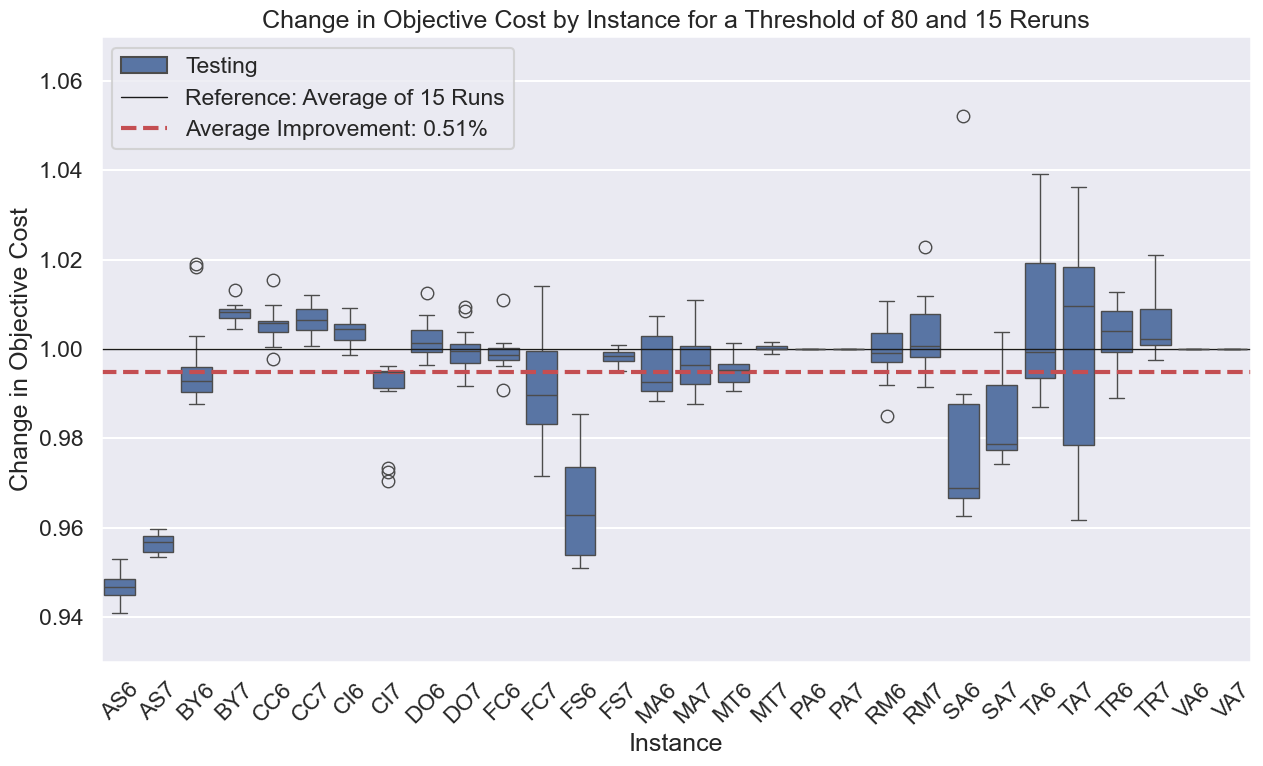

In [21]:
plt.figure(figsize=(13, 8))

average_objective_improvement=df["finalObjective"].mean()
n_runs = finalObjectiveByInstance[('finalObjective', 'count')].median()

#sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Set");
sns.boxplot(data=df.fillna("Original"), x="Instance", y="finalObjective",
           # hue="Threshold", hue_order=[80.0, "Original"]
            hue="Subset"
           );
#sns.boxplot(data=df[(df.Threshold==th)], x="Instance", y="finalObjective", hue="Subset");
plt.axhline(1, c="k", ls="-", lw=1, label=f"Reference: Average of {n_runs:.0f} Runs")
plt.axhline(average_objective_improvement, ls="--", c="r", lw=3, label=f"Average Improvement: {1-average_objective_improvement:.2%}")
plt.ylabel("Change in Objective Cost");
plt.title(
    f"Change in Objective Cost by Instance for a Threshold of 80 and {n_runs:.0f} Reruns");
plt.xticks(rotation=45);
plt.ylim([0.93, 1.07])
plt.legend()

plt.tight_layout()
for file_format in ["pdf"]:
    #path = os.path.join(cwd, "plots", "2024-04-18-ExperimentsThreshold-FIXED", f"Change in Objective by Instance 70-95.{file_format}")
    path = os.path.join(cwd, "plots", "2024-04-23-ExperimentsThreshold-RERUN", f"Change in Objective by Instance.{file_format}")
    plt.savefig(path)


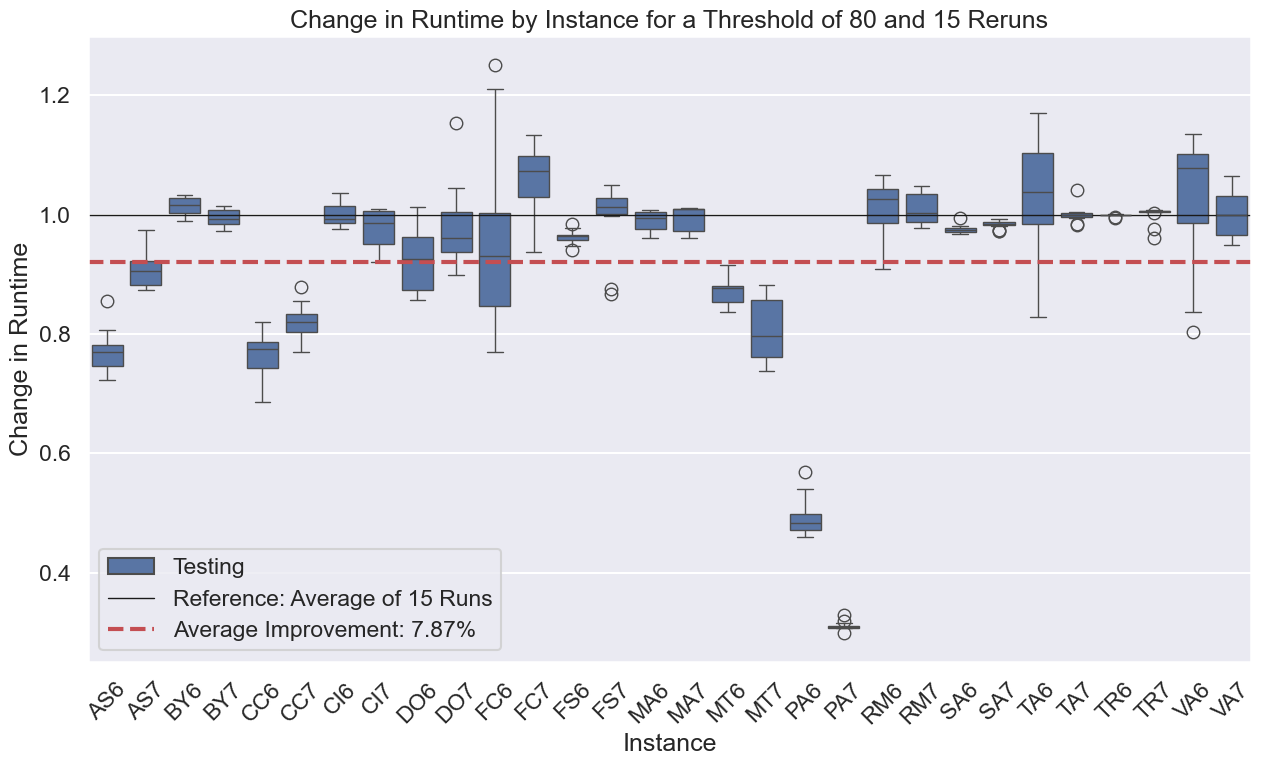

In [31]:
plt.figure(figsize=(13, 8))

average_objective_runtime=df["Runtime"].mean()
n_runs = finalObjectiveByInstance[('finalObjective', 'count')].median()

#sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Set");
sns.boxplot(data=df[(70<df.Threshold)&(df.Threshold< 100)], x="Instance", y="Runtime", hue="Subset");
#sns.boxplot(data=df[(df.Threshold==th)], x="Instance", y="finalObjective", hue="Subset");

plt.axhline(1, c="k", ls="-", lw=1, label=f"Reference: Average of {n_runs:.0f} Runs")
plt.axhline(average_objective_runtime, ls="--", c="r", lw=3, label=f"Average Improvement: {1-average_objective_runtime:.2%}")
plt.ylabel("Change in Runtime");
plt.title(
    f"Change in Runtime by Instance for a Threshold of 80 and {n_runs:.0f} Reruns");
plt.xticks(rotation=45);
#plt.ylim([0.93, 1.07])
plt.legend();
plt.tight_layout()
for file_format in ["pdf"]:
    #path = os.path.join(cwd, "plots", "2024-04-18-ExperimentsThreshold-FIXED", f"Change in Objective by Instance 70-95.{file_format}")
    path = os.path.join(cwd, "plots", "2024-04-23-ExperimentsThreshold-RERUN", f"Change in Runtime by Instance.{file_format}")
    plt.savefig(path)


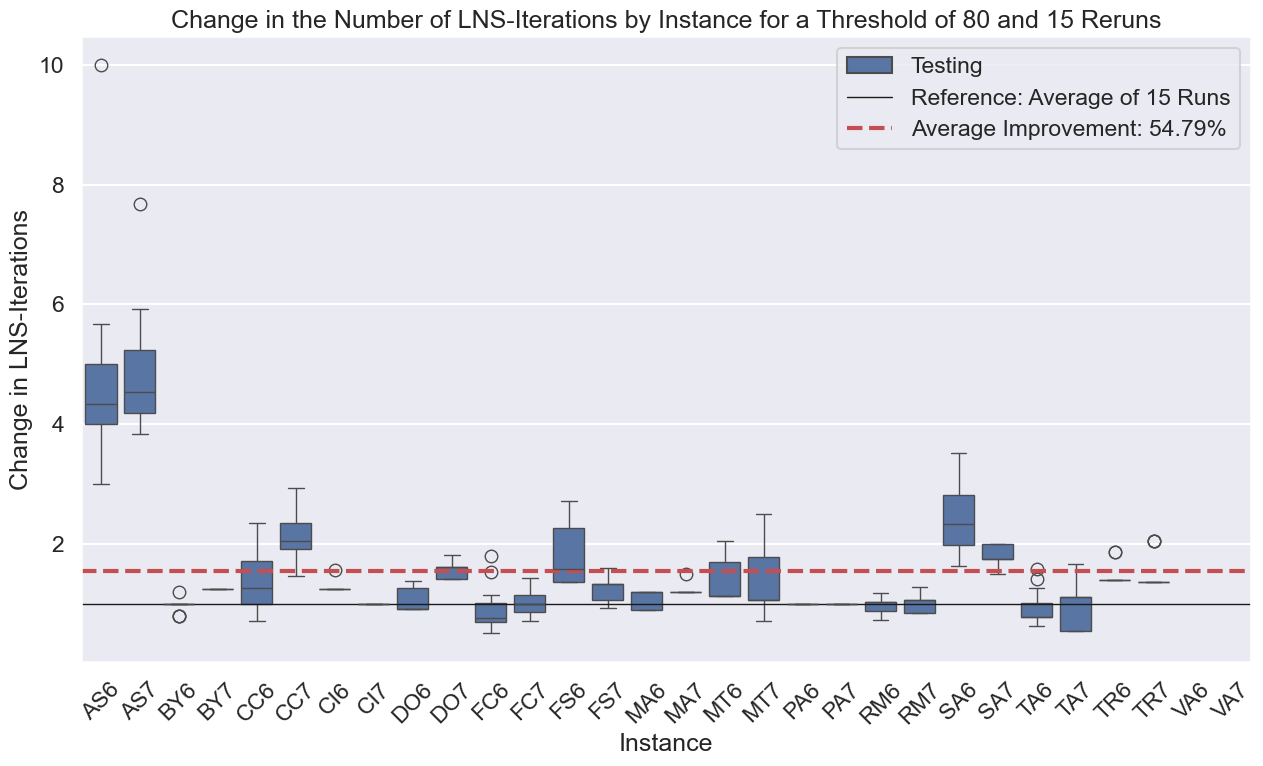

In [32]:
plt.figure(figsize=(13, 8))

average_objective_runtime=df["num_LNS_iter"].mean()
n_runs = finalObjectiveByInstance[('finalObjective', 'count')].median()

#sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Set");
sns.boxplot(data=df[(70<df.Threshold)&(df.Threshold< 100)], x="Instance", y="num_LNS_iter", hue="Subset");
#sns.boxplot(data=df[(df.Threshold==th)], x="Instance", y="finalObjective", hue="Subset");
plt.axhline(1, c="k", ls="-", lw=1, label=f"Reference: Average of {n_runs:.0f} Runs")
plt.axhline(average_objective_runtime, ls="--", c="r", lw=3, label=f"Average Improvement: {average_objective_runtime-1:.2%}")
plt.ylabel("Change in LNS-Iterations");
plt.title(
    f"Change in the Number of LNS-Iterations by Instance for a Threshold of 80 and {n_runs:.0f} Reruns");
plt.xticks(rotation=45);
#plt.ylim([0.93, 1.07])
plt.legend();

plt.tight_layout()
for file_format in ["pdf"]:
    #path = os.path.join(cwd, "plots", "2024-04-18-ExperimentsThreshold-FIXED", f"Change in Objective by Instance 70-95.{file_format}")
    path = os.path.join(cwd, "plots", "2024-04-23-ExperimentsThreshold-RERUN", f"Change in LNS-Iterations by Instance.{file_format}")
    plt.savefig(path)


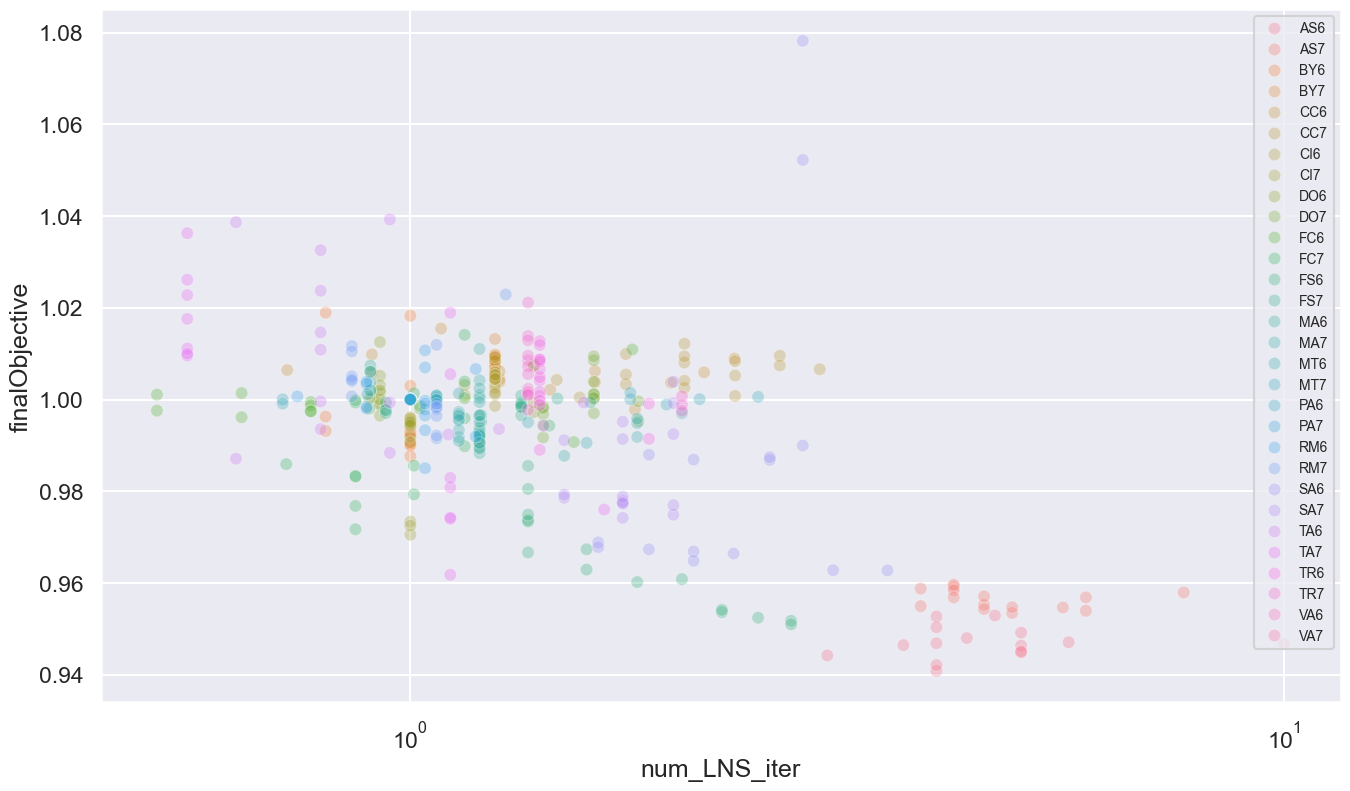

In [33]:
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df, x="num_LNS_iter", y="finalObjective", 
                hue="Instance",
                alpha=0.3,);
plt.xscale("log")
plt.legend(fontsize=10);